# KMClib- ZGB model

This notebook reproduces Fig. 4 of [R. M. Ziff, E. Gulari, and Y. Barshad, Phys. Rev. Lett., 56, 2553–2556 (1986).](http://doi.org/10.1103/PhysRevLett.56.2553)

 * uses [KMCLib as forked by scbarton](https://github.com/scbarton/KMCLib-scb)
 * requires [pandas](https://pandas.pydata.org)
 
This model simulates CO oxidation on a surface modeled as a rectangular grid. Only adsorption and reaction processes are considered, the atmosphere is assumed to be composed of only CO and O<sub>2</sub>, and oxygen adsorption is treated as dissociative. The surface oxidation reaction is considered fast, so that the overall rate is adsorption limited.  The reaction is oxygen poisoned at low CO partial pressure and CO poisoned at high CO partial pressure.

In [1]:
%pylab inline
import random
from __future__ import division
from KMCLib import *
import pandas as pd
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib
# -----------------------------------------------------------------------------
# KMCLib version 2.0-a1
# Distributed under the GPLv3 license
# Copyright (C)  2012-2016  Mikael Leetmaa
# Developed by Mikael Leetmaa <leetmaa@kth.se>
#
# This program is distributed in the hope that it will be useful
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# LICENSE and README files, and the source code, for details.
#
# You should have received a copy of the GNU General Public License version 3
# (GPLv3) along with this program. If not, see <http://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------



## Parameters

In [2]:
N=100     # size of domain
ptot=1.0  # gas total pressure in atm
yCO=0.5   # mole fraction CO in gas phase
yO2= 1.0 - yCO    # mole fraction O2 in gas phase

## Rate Constants

In [3]:
class Struct(): pass
k=Struct()

k.COads=yCO*ptot
k.O2ads=yO2*ptot
k.s= 1000.

k0=deepcopy(k)  # Backup baseline k

## Initial Configuration

In [4]:
# Unit Cell
cell_vectors = [[   1.000000e+00,   0.000000e+00,   0.000000e+00],
                [   0.000000e+00,   1.000000e+00,   0.000000e+00],
                [   0.000000e+00,   0.000000e+00,   1.000000e+00]]
basis_points = [[   0.000000e+00,   0.000000e+00,   0.000000e+00]]
unit_cell = KMCUnitCell(cell_vectors=cell_vectors,
                        basis_points=basis_points)

# Define the lattice.
lattice = KMCLattice(unit_cell=unit_cell,
                 repetitions=(N,N,1),
                 periodic=(True, True, False))
# Generate the initial types.
possible_types=['O','CO','S']

# initially empty surface
typesinit = ['S']*(N**2)

# random coverage
# types = [random.choice(possible_types) for ii in range(N**2)]

## Interactions

In [5]:
def interactions():
    from collections import OrderedDict
    coordinates = [[   0.000000e+00,   0.000000e+00,   0.000000e+00]]
    process=OrderedDict()

    # CO Adsorption
    process['COads'] = KMCProcess(coordinates=coordinates,
                       elements_before=['S'],
                       elements_after=['CO'],
                       basis_sites=[0],
                       rate_constant=k.COads )

    # O2 Dissociative Adsorption
    process['O2adsU'] = KMCProcess(coordinates=[[0.,0.,0.],[1.,0.,0.]],
                       elements_before=['S','S'], elements_after=['O','O'],
                       basis_sites=[0], rate_constant=k.O2ads/4.0)

    process['O2adsD'] = KMCProcess(coordinates=[[0.,0.,0.],[-1.,0.,0.]],
                       elements_before=['S','S'], elements_after=['O','O'],
                       basis_sites=[0], rate_constant=k.O2ads/4.0)

    process['O2adsL'] = KMCProcess(coordinates=[[0.,0.,0.],[0.,-1.,0.]],
                       elements_before=['S','S'], elements_after=['O','O'],
                       basis_sites=[0], rate_constant=k.O2ads/4.0)

    process['O2adsR'] = KMCProcess(coordinates=[[0.,0.,0.],[0.,1.,0.]],
                       elements_before=['S','S'], elements_after=['O','O'],
                       basis_sites=[0], rate_constant=k.O2ads/4.0)

    # CO + O -> CO2 oxidation process
    process['oxidationU'] =KMCProcess(coordinates=[[0.,0.,0.],[1.,0.,0.]],
                       elements_before=['CO','O'], elements_after=['S','S'],
                       basis_sites=[0], rate_constant=k.s/4.0)

    process['oxidationD'] =KMCProcess(coordinates=[[0.,0.,0.],[-1.,0.,0.]],
                       elements_before=['CO','O'], elements_after=['S','S'],
                       basis_sites=[0], rate_constant=k.s/4.0)

    process['oxidationL'] =KMCProcess(coordinates=[[0.,0.,0.],[0.,-1.,0.]],
                       elements_before=['CO','O'], elements_after=['S','S'],
                       basis_sites=[0], rate_constant=k.s/4.0)

    process['oxidationR'] =KMCProcess(coordinates=[[0.,0.,0.],[0.,1.,0.]],
                       elements_before=['CO','O'], elements_after=['S','S'],
                       basis_sites=[0], rate_constant=k.s/4.0)
    
    # remove processes with zero rate constant
    for key, p in process.items():
        if p.rateConstant()==0:
            del process[key]
    
    return process

## Main calculation

In [6]:
def ZGBrun(label='zgb_traj'):
    
    # Setup the configuration.
    configuration = KMCConfiguration(lattice=lattice,
                             types=typesinit,
                             possible_types=possible_types)   

    # Create the interactions object
    interactions = KMCInteractions(processes=process.values(),
                                   implicit_wildcards=True)

    # Create the model.
    model = KMCLatticeModel(configuration, interactions)

    #process analysis
    process_analysis = ProcessStatistics(processes=range(len(process.values())))

    # Define the parameters.
    control_parameters = KMCControlParameters(number_of_steps=1000000,
                                              dump_interval=10000,
                                              analysis_interval=1)
    
    # Run the simulation and save trajectory 
    # Here we catch errors in the case where the surface is poisoned and
    # no processes are possible.
    
    error_val=0
    
    try:
        model.run(control_parameters, trajectory_filename=label+'.py',
                  analysis=[process_analysis])
    except Exception as e:
       error_val=1
        
    # load the trajectory
    trj={}
    execfile(label+'.py',trj)
           
    # surface coverages for every species
    theta={}
    for s in possible_types:
        theta[s]=[sum(array(t)==s)/len(t) for t in trj['types'] ]
    trj['theta']=theta    
    
    # reaction rates for every process
    rT=process_analysis.proc_data.transpose()
    d={key:rT[ii] for ii, key in enumerate(process.keys())}
    df=pd.DataFrame(d,index=process_analysis.time)
    df.index.name='Time'
    df['O2ads']=df.filter(regex='O2ads').sum(axis=1)
    df['O2des']=df.filter(regex='O2des').sum(axis=1)
    df['oxidation']=df.filter(regex='oxidation').sum(axis=1)

    return trj, df, error_val

## yCO sweep

In [7]:
typesinit = ['S']*(N**2)  # initially empty surface
k=deepcopy(k0)   # reset k to baseline

yv=linspace(0.3,0.6,31)
QO,QCO,TOF= [],[],[]

for yCO in yv:
    
    yO2=1-yCO
    k.COads=yCO*ptot
    k.O2ads=yO2*ptot
    
    process=interactions()
    trj, rates, error_val = ZGBrun()
    
    Nt=len(trj['types'])
    
    if error_val==1:
        QO  += [ trj['theta']['O' ][Nt-1] ]
        QCO += [ trj['theta']['CO'][Nt-1] ]

        TOF += [0.0]
    else:
        QO  += [ mean(trj['theta']['O' ][int(0.9*Nt):Nt]) ]
        QCO += [ mean(trj['theta']['CO'][int(0.9*Nt):Nt]) ]

        Na=len(rates.index)
        TOF += [ mean(rates['oxidation'][int(0.9*Na):Na])/N**2 ]

 KMCLib: setting up the backend C++ object.
 KMCLib: Running for 1000000 steps, starting from time: 0.000000

 KMCLib: 10000 steps executed. time:     1.6646242326e+00 
 KMCLib: 20000 steps executed. time:     5.9323167952e+00 
 KMCLib: 30000 steps executed. time:     1.4214588973e+01 
 KMCLib: 40000 steps executed. time:     2.8935621821e+01 
 KMCLib: 50000 steps executed. time:     7.5117399973e+01 
 KMCLib: 52311 steps executed. time:     2.2751203642e+02 
 KMCLib: setting up the backend C++ object.
 KMCLib: Running for 1000000 steps, starting from time: 0.000000

 KMCLib: 10000 steps executed. time:     1.6264345344e+00 
 KMCLib: 20000 steps executed. time:     5.8533081690e+00 
 KMCLib: 30000 steps executed. time:     1.3624782174e+01 
 KMCLib: 40000 steps executed. time:     2.7889958431e+01 
 KMCLib: 50000 steps executed. time:     7.0905292398e+01 
 KMCLib: 53871 steps executed. time:     1.9141027000e+02 
 KMCLib: setting up the backend C++ object.
 KMCLib: Running for 1000000

 KMCLib: 420000 steps executed. time:     1.0596383597e+03 
 KMCLib: 430000 steps executed. time:     1.1334911603e+03 
 KMCLib: 440000 steps executed. time:     1.2040870804e+03 
 KMCLib: 450000 steps executed. time:     1.2698984231e+03 
 KMCLib: 460000 steps executed. time:     1.3896757962e+03 
 KMCLib: 470000 steps executed. time:     1.5531185209e+03 
 KMCLib: 474846 steps executed. time:     1.6964653720e+03 
 KMCLib: setting up the backend C++ object.
 KMCLib: Running for 1000000 steps, starting from time: 0.000000

 KMCLib: 10000 steps executed. time:     1.2636947155e+00 
 KMCLib: 20000 steps executed. time:     3.3374988676e+00 
 KMCLib: 30000 steps executed. time:     6.3352263364e+00 
 KMCLib: 40000 steps executed. time:     1.0051210095e+01 
 KMCLib: 50000 steps executed. time:     1.4921042509e+01 
 KMCLib: 60000 steps executed. time:     2.0434389377e+01 
 KMCLib: 70000 steps executed. time:     2.6917237796e+01 
 KMCLib: 80000 steps executed. time:     3.4087108740e+01

 KMCLib: 290000 steps executed. time:     2.0120216577e+02 
 KMCLib: 300000 steps executed. time:     2.1021103827e+02 
 KMCLib: 310000 steps executed. time:     2.1926110726e+02 
 KMCLib: 320000 steps executed. time:     2.2822329819e+02 
 KMCLib: 330000 steps executed. time:     2.3702163647e+02 
 KMCLib: 340000 steps executed. time:     2.4610001577e+02 
 KMCLib: 350000 steps executed. time:     2.5578571807e+02 
 KMCLib: 360000 steps executed. time:     2.6580790785e+02 
 KMCLib: 370000 steps executed. time:     2.7628768083e+02 
 KMCLib: 380000 steps executed. time:     2.8646661768e+02 
 KMCLib: 390000 steps executed. time:     2.9612136180e+02 
 KMCLib: 400000 steps executed. time:     3.0607448023e+02 
 KMCLib: 410000 steps executed. time:     3.1581411460e+02 
 KMCLib: 420000 steps executed. time:     3.2612814721e+02 
 KMCLib: 430000 steps executed. time:     3.3618151425e+02 
 KMCLib: 440000 steps executed. time:     3.4667576797e+02 
 KMCLib: 450000 steps executed. time:   

 KMCLib: 640000 steps executed. time:     4.0402630895e+02 
 KMCLib: 650000 steps executed. time:     4.1093661417e+02 
 KMCLib: 660000 steps executed. time:     4.1775930353e+02 
 KMCLib: 670000 steps executed. time:     4.2471872118e+02 
 KMCLib: 680000 steps executed. time:     4.3179726132e+02 
 KMCLib: 690000 steps executed. time:     4.3858263840e+02 
 KMCLib: 700000 steps executed. time:     4.4570450086e+02 
 KMCLib: 710000 steps executed. time:     4.5296730469e+02 
 KMCLib: 720000 steps executed. time:     4.6030609429e+02 
 KMCLib: 730000 steps executed. time:     4.6715835813e+02 
 KMCLib: 740000 steps executed. time:     4.7379441082e+02 
 KMCLib: 750000 steps executed. time:     4.8028551104e+02 
 KMCLib: 760000 steps executed. time:     4.8670090067e+02 
 KMCLib: 770000 steps executed. time:     4.9342743385e+02 
 KMCLib: 780000 steps executed. time:     4.9983478783e+02 
 KMCLib: 790000 steps executed. time:     5.0634054524e+02 
 KMCLib: 800000 steps executed. time:   

 KMCLib: 1000000 steps executed. time:     5.1835248838e+02 
 KMCLib: setting up the backend C++ object.
 KMCLib: Running for 1000000 steps, starting from time: 0.000000

 KMCLib: 10000 steps executed. time:     1.1822581219e+00 
 KMCLib: 20000 steps executed. time:     2.7781765413e+00 
 KMCLib: 30000 steps executed. time:     4.8384426486e+00 
 KMCLib: 40000 steps executed. time:     7.3018152895e+00 
 KMCLib: 50000 steps executed. time:     1.0276269382e+01 
 KMCLib: 60000 steps executed. time:     1.3494587591e+01 
 KMCLib: 70000 steps executed. time:     1.7115984794e+01 
 KMCLib: 80000 steps executed. time:     2.0867159650e+01 
 KMCLib: 90000 steps executed. time:     2.4750412046e+01 
 KMCLib: 100000 steps executed. time:     2.8783293808e+01 
 KMCLib: 110000 steps executed. time:     3.2978044226e+01 
 KMCLib: 120000 steps executed. time:     3.7194526202e+01 
 KMCLib: 130000 steps executed. time:     4.1441377707e+01 
 KMCLib: 140000 steps executed. time:     4.5680712942e+01

 KMCLib: 340000 steps executed. time:     1.1726667279e+02 
 KMCLib: 350000 steps executed. time:     1.2123145615e+02 
 KMCLib: 360000 steps executed. time:     1.2511801566e+02 
 KMCLib: 370000 steps executed. time:     1.2894637912e+02 
 KMCLib: 380000 steps executed. time:     1.3294752193e+02 
 KMCLib: 390000 steps executed. time:     1.3711643068e+02 
 KMCLib: 400000 steps executed. time:     1.4112882457e+02 
 KMCLib: 410000 steps executed. time:     1.4521258389e+02 
 KMCLib: 420000 steps executed. time:     1.4922759319e+02 
 KMCLib: 430000 steps executed. time:     1.5323143462e+02 
 KMCLib: 440000 steps executed. time:     1.5734795564e+02 
 KMCLib: 450000 steps executed. time:     1.6146471675e+02 
 KMCLib: 460000 steps executed. time:     1.6560918569e+02 
 KMCLib: 470000 steps executed. time:     1.6940188151e+02 
 KMCLib: 480000 steps executed. time:     1.7306334261e+02 
 KMCLib: 490000 steps executed. time:     1.7689498266e+02 
 KMCLib: 500000 steps executed. time:   

 KMCLib: 690000 steps executed. time:     2.1993189746e+02 
 KMCLib: 700000 steps executed. time:     2.2351779964e+02 
 KMCLib: 710000 steps executed. time:     2.2695684060e+02 
 KMCLib: 720000 steps executed. time:     2.3048773653e+02 
 KMCLib: 730000 steps executed. time:     2.3391248136e+02 
 KMCLib: 740000 steps executed. time:     2.3721433888e+02 
 KMCLib: 750000 steps executed. time:     2.4069675730e+02 
 KMCLib: 760000 steps executed. time:     2.4424130760e+02 
 KMCLib: 770000 steps executed. time:     2.4773414131e+02 
 KMCLib: 780000 steps executed. time:     2.5102180696e+02 
 KMCLib: 790000 steps executed. time:     2.5443539746e+02 
 KMCLib: 800000 steps executed. time:     2.5783856456e+02 
 KMCLib: 810000 steps executed. time:     2.6126962625e+02 
 KMCLib: 820000 steps executed. time:     2.6447974750e+02 
 KMCLib: 830000 steps executed. time:     2.6778463358e+02 
 KMCLib: 840000 steps executed. time:     2.7126720582e+02 
 KMCLib: 850000 steps executed. time:   

 KMCLib: 30000 steps executed. time:     4.1129399424e+00 
 KMCLib: 40000 steps executed. time:     5.9926228398e+00 
 KMCLib: 50000 steps executed. time:     8.0553201719e+00 
 KMCLib: 60000 steps executed. time:     1.0208996267e+01 
 KMCLib: 70000 steps executed. time:     1.2510974522e+01 
 KMCLib: 80000 steps executed. time:     1.4878225359e+01 
 KMCLib: 90000 steps executed. time:     1.7377503984e+01 
 KMCLib: 100000 steps executed. time:     1.9903136723e+01 
 KMCLib: 110000 steps executed. time:     2.2551511876e+01 
 KMCLib: 120000 steps executed. time:     2.5152715891e+01 
 KMCLib: 130000 steps executed. time:     2.7882121315e+01 
 KMCLib: 140000 steps executed. time:     3.0590838166e+01 
 KMCLib: 150000 steps executed. time:     3.3256515994e+01 
 KMCLib: 160000 steps executed. time:     3.5873485827e+01 
 KMCLib: 170000 steps executed. time:     3.8496037329e+01 
 KMCLib: 180000 steps executed. time:     4.1057951189e+01 
 KMCLib: 190000 steps executed. time:     4.366

 KMCLib: 380000 steps executed. time:     8.3982428865e+01 
 KMCLib: 390000 steps executed. time:     8.6397923179e+01 
 KMCLib: 400000 steps executed. time:     8.8801485780e+01 
 KMCLib: 410000 steps executed. time:     9.1185169203e+01 
 KMCLib: 420000 steps executed. time:     9.3564874206e+01 
 KMCLib: 430000 steps executed. time:     9.5940137014e+01 
 KMCLib: 440000 steps executed. time:     9.8433212673e+01 
 KMCLib: 450000 steps executed. time:     1.0087702784e+02 
 KMCLib: 460000 steps executed. time:     1.0331215707e+02 
 KMCLib: 470000 steps executed. time:     1.0567897926e+02 
 KMCLib: 480000 steps executed. time:     1.0798619776e+02 
 KMCLib: 490000 steps executed. time:     1.1029827794e+02 
 KMCLib: 500000 steps executed. time:     1.1261990896e+02 
 KMCLib: 510000 steps executed. time:     1.1499449527e+02 
 KMCLib: 520000 steps executed. time:     1.1737391883e+02 
 KMCLib: 530000 steps executed. time:     1.1972562679e+02 
 KMCLib: 540000 steps executed. time:   

 KMCLib: 730000 steps executed. time:     1.5097359307e+02 
 KMCLib: 740000 steps executed. time:     1.5313190410e+02 
 KMCLib: 750000 steps executed. time:     1.5532531847e+02 
 KMCLib: 760000 steps executed. time:     1.5759867715e+02 
 KMCLib: 770000 steps executed. time:     1.5982815004e+02 
 KMCLib: 780000 steps executed. time:     1.6203045314e+02 
 KMCLib: 790000 steps executed. time:     1.6419722175e+02 
 KMCLib: 800000 steps executed. time:     1.6638614606e+02 
 KMCLib: 810000 steps executed. time:     1.6852774898e+02 
 KMCLib: 820000 steps executed. time:     1.7068109942e+02 
 KMCLib: 830000 steps executed. time:     1.7288359026e+02 
 KMCLib: 840000 steps executed. time:     1.7496381425e+02 
 KMCLib: 850000 steps executed. time:     1.7706066691e+02 
 KMCLib: 860000 steps executed. time:     1.7917381695e+02 
 KMCLib: 870000 steps executed. time:     1.8123750173e+02 
 KMCLib: 880000 steps executed. time:     1.8339706080e+02 
 KMCLib: 890000 steps executed. time:   

 KMCLib: 80000 steps executed. time:     1.1057438789e+01 
 KMCLib: 90000 steps executed. time:     1.2668953684e+01 
 KMCLib: 100000 steps executed. time:     1.4289008546e+01 
 KMCLib: 110000 steps executed. time:     1.5909228049e+01 
 KMCLib: 120000 steps executed. time:     1.7601425129e+01 
 KMCLib: 130000 steps executed. time:     1.9287603539e+01 
 KMCLib: 140000 steps executed. time:     2.1050423819e+01 
 KMCLib: 150000 steps executed. time:     2.2770174869e+01 
 KMCLib: 160000 steps executed. time:     2.4490371098e+01 
 KMCLib: 170000 steps executed. time:     2.6218679230e+01 
 KMCLib: 180000 steps executed. time:     2.7990759258e+01 
 KMCLib: 190000 steps executed. time:     2.9743179902e+01 
 KMCLib: 200000 steps executed. time:     3.1480012305e+01 
 KMCLib: 210000 steps executed. time:     3.3186014407e+01 
 KMCLib: 220000 steps executed. time:     3.4951357312e+01 
 KMCLib: 230000 steps executed. time:     3.6737402094e+01 
 KMCLib: 240000 steps executed. time:     

 KMCLib: 430000 steps executed. time:     6.6507588073e+01 
 KMCLib: 440000 steps executed. time:     6.8122738879e+01 
 KMCLib: 450000 steps executed. time:     6.9759831019e+01 
 KMCLib: 460000 steps executed. time:     7.1380699887e+01 
 KMCLib: 470000 steps executed. time:     7.3011854791e+01 
 KMCLib: 480000 steps executed. time:     7.4649375667e+01 
 KMCLib: 490000 steps executed. time:     7.6248631968e+01 
 KMCLib: 500000 steps executed. time:     7.7877215380e+01 
 KMCLib: 510000 steps executed. time:     7.9447994463e+01 
 KMCLib: 520000 steps executed. time:     8.0964578910e+01 
 KMCLib: 530000 steps executed. time:     8.2497720640e+01 
 KMCLib: 540000 steps executed. time:     8.4038010200e+01 
 KMCLib: 550000 steps executed. time:     8.5575983638e+01 
 KMCLib: 560000 steps executed. time:     8.7075938487e+01 
 KMCLib: 570000 steps executed. time:     8.8580081914e+01 
 KMCLib: 580000 steps executed. time:     9.0130000070e+01 
 KMCLib: 590000 steps executed. time:   

 KMCLib: 780000 steps executed. time:     1.1371126329e+02 
 KMCLib: 790000 steps executed. time:     1.1519865625e+02 
 KMCLib: 800000 steps executed. time:     1.1672431733e+02 
 KMCLib: 810000 steps executed. time:     1.1823625223e+02 
 KMCLib: 820000 steps executed. time:     1.1973464877e+02 
 KMCLib: 830000 steps executed. time:     1.2121167258e+02 
 KMCLib: 840000 steps executed. time:     1.2270476679e+02 
 KMCLib: 850000 steps executed. time:     1.2423588868e+02 
 KMCLib: 860000 steps executed. time:     1.2575803323e+02 
 KMCLib: 870000 steps executed. time:     1.2729303651e+02 
 KMCLib: 880000 steps executed. time:     1.2886968687e+02 
 KMCLib: 890000 steps executed. time:     1.3045193681e+02 
 KMCLib: 900000 steps executed. time:     1.3200326829e+02 
 KMCLib: 910000 steps executed. time:     1.3354371439e+02 
 KMCLib: 920000 steps executed. time:     1.3509336924e+02 
 KMCLib: 930000 steps executed. time:     1.3661415714e+02 
 KMCLib: 940000 steps executed. time:   

 KMCLib: 20000 steps executed. time:     2.1504496306e+00 
 KMCLib: 30000 steps executed. time:     3.3273190416e+00 
 KMCLib: 40000 steps executed. time:     4.6110578487e+00 
 KMCLib: 50000 steps executed. time:     5.9067262294e+00 
 KMCLib: 60000 steps executed. time:     7.2511850398e+00 
 KMCLib: 70000 steps executed. time:     8.6605436510e+00 
 KMCLib: 80000 steps executed. time:     1.0081726520e+01 
 KMCLib: 90000 steps executed. time:     1.1545473253e+01 
 KMCLib: 100000 steps executed. time:     1.3061738644e+01 
 KMCLib: 110000 steps executed. time:     1.4667998013e+01 
 KMCLib: 120000 steps executed. time:     1.6386547749e+01 
 KMCLib: 130000 steps executed. time:     1.8192472238e+01 
 KMCLib: 140000 steps executed. time:     2.0050301086e+01 
 KMCLib: 150000 steps executed. time:     2.2024403785e+01 
 KMCLib: 160000 steps executed. time:     2.4099015660e+01 
 KMCLib: 170000 steps executed. time:     2.6391736084e+01 
 KMCLib: 180000 steps executed. time:     2.8951

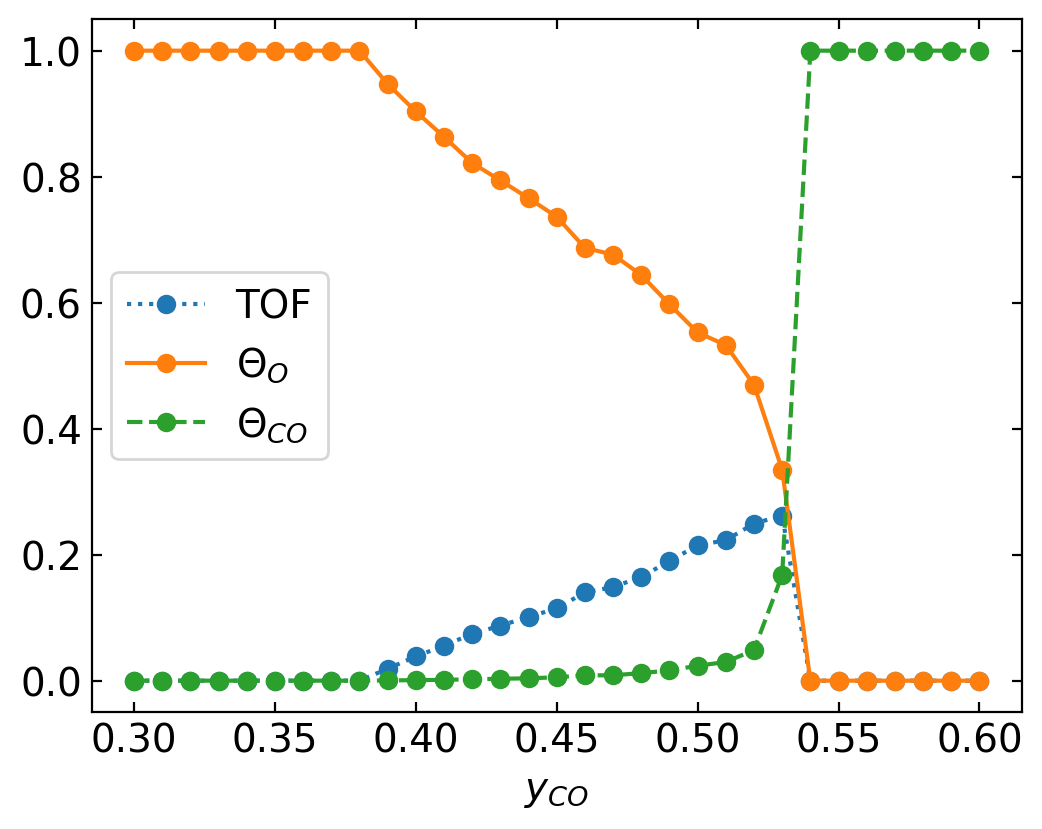

In [8]:
plot(yv,TOF,':o')
plot(yv,QO,'-o')
plot(yv,QCO,'--o')
legend(['TOF','$\Theta_O$','$\Theta_{CO}$'])
xlabel('$y_{CO}$')
show()

These results compare well with Figure 4 of ZGB:
![](ZGB_Fig4.png)